In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 加载数据

In [44]:
data = pd.read_csv("input/creditcard.csv")
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


## 分析

对类别进行一个统计，看看数据的不均衡程度：

0    284315
1       492
Name: Class, dtype: int64


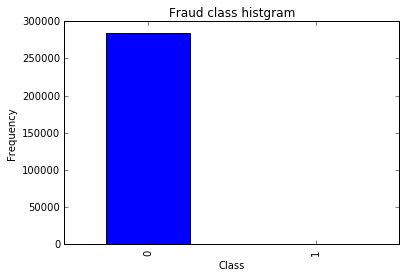

In [179]:
count_class = pd.value_counts(data['Class'], sort=True).sort_index()
print(count_class)

count_class.plot(kind='bar')
plt.title("Fraud class histgram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

可以看到确实只有492条的Class为1（属于诈骗），数据非常不均衡。

对于样本不平衡的分类问题，可以用以下方法：

- 收集更多数据。显然这里不可行
- 使用别的性能指标（performance metric）:
  - Use the confusio nmatrix to calculate Precision, Recall
  - F1score (weighted average of precision recall)
  - Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
  - ROC curves - calculates sensitivity/specificity ratio.
- 重采样
  - Essentially this is a method that will process the data to have an approximate 50-50 ratio.
  - One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when you have little data)
  - Another is UNDER-sampling, which deletes instances from the over-represented class (better when he have lot's of data)

## Approach

1. 第一步需要的特征工程这里并不需要处理，因为数据集已经降维到30个特征（28个匿名特征+time+amount）。
2. 我们会基于一个简单的逻辑回归分类比较使用重采样与不使用重采样的情况。
3. 我们会使用上面提到的几个性能指标来对模型进行评估。
4. We will repeat the best resampling/not resampling method, by tuning the parameters in the logistic regression classifier.
5. We will finally perform classifications model using other classification algorithms.

## 数据准备

虽然无需特征处理，但也需要进行一些简单的数据处理，例如Amount特征标准化、重采样、训练集数据集划分等。


### 1. 规范化Amount特征


In [46]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].reshape(-1, 1))
data.drop(['Time', 'Amount'], axis=1, inplace=True)
data.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,0,-0.338556
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,0,-0.333279
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0,-0.190107
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0,0.019392
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,0,-0.338516


### 2. 将数据拆分成特征和标签

In [47]:
X = data.ix[:, data.columns != 'Class']
y = data.ix[:, data.columns == 'Class']

### 3. 欠采样

这里使用最简单的欠采样的方法来得到一份分布均衡的样本：有多少欺诈交易就从正常交易中随机选择多少条记录。
有一个叫做SMOTE的过采样方法很流行，如果要过采样的话可以采用，这里暂不使用。

In [48]:
# 少数类（欺诈交易）的数量，这些交易的index
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# 从正常交易的index中 随机选出 跟欺诈交易数量相等的index
normal_indices = data[data.Class == 0].index
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)

# 要采样数据的index
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# 欠采样得到的数据
under_sample_data = data.iloc[under_sample_indices, :]

X_undersample = under_sample_data.ix[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.ix[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


### 4.划分数据集、测试集

In [56]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions train dataset: ", X_train.shape[0])
print("Number transactions test dataset", X_test.shape[0])
print("Total number of transactions: ", len(X_train) + len(X_test))

X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = \
train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=0)

print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample) + len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset 85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


## 基于欠采样数据集的逻辑回归分类

我们将重点考虑召回率（recall），它能帮助我们尽可能多的识别信用卡诈骗。

- Accuracy= (TP+TN) / total  精度
- Precision = TP / (TP + FP) 准确率、查准率
- Recall = TP / (TP + FN)    召回率、查全率

我个人对Precision和Recall通俗的理解：

- Precision：判别为正例的结果中真正例的比率
- Recall：所有正例中，判别结果是正例的比率

这里比较多个逻辑回归的参数，寻找一个最优的参数

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, \
recall_score, classification_report, auc

k折交叉验证函数（带有score的print）：

In [65]:
def print_Kfold_scores(X_train_data, y_train_data):
    fold = KFold(len(y_train_data), 5, shuffle=False)
    
    # 候选C_param
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    result_table = pd.DataFrame(index=range(len(c_param_range), 2), columns=['C_parameter', 'Mean recall score'])
    result_table['C_parameter'] = c_param_range
    
    j = 0
    for c_param in c_param_range:
        print('=====================================')
        print('C parameter: ', c_param)
        print('-------------------------------------')
        print('')
        
        recall_accs = []
        # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
        for iteration, indices in enumerate(fold, start=1):
            # 建立逻辑回归模型
            lr = LogisticRegression(C = c_param, penalty='l1')
            # 训练
            lr.fit(X_train_data.iloc[indices[0], :], y_train_data.iloc[indices[0], :].values.ravel())
            # 预测
            y_pred_undersample = lr.predict(X_train_data.iloc[indices[1], :].values)
            
            # 召回率计算
            recall_acc = recall_score(y_train_data.iloc[indices[1], :].values, y_pred_undersample)
            recall_accs.append(recall_acc)
            
            print('Iteration ', iteration, ' recall score: ', recall_acc)
            
        result_table.ix[j, 'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    # 召回率最高的C_param
    best_c = result_table.loc[result_table['Mean recall score'].idxmax()]['C_parameter']
    
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [66]:
best_c = print_Kfold_scores(X_train_undersample, y_train_undersample)

C parameter:  0.01
-------------------------------------

Iteration  1  recall score:  0.931506849315
Iteration  2  recall score:  0.917808219178
Iteration  3  recall score:  1.0
Iteration  4  recall score:  0.959459459459
Iteration  5  recall score:  0.954545454545

Mean recall score  0.9526639965

C parameter:  0.1
-------------------------------------

Iteration  1  recall score:  0.849315068493
Iteration  2  recall score:  0.86301369863
Iteration  3  recall score:  0.932203389831
Iteration  4  recall score:  0.945945945946
Iteration  5  recall score:  0.909090909091

Mean recall score  0.899913802398

C parameter:  1
-------------------------------------

Iteration  1  recall score:  0.849315068493
Iteration  2  recall score:  0.904109589041
Iteration  3  recall score:  0.983050847458
Iteration  4  recall score:  0.945945945946
Iteration  5  recall score:  0.924242424242

Mean recall score  0.921332775036

C parameter:  10
-------------------------------------

Iteration  1  recall

## 基于欠采样数据进行预测，绘制混淆矩阵

首先定义绘制混淆矩阵的函数：

In [122]:
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title="Confusion matrix",
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap) #interpolation：插值
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0) # x刻度 第一个参数是location，第二个参数是label
    plt.yticks(tick_marks, classes) # y刻度
    
    # 归一化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1
    
    # 给每个区域写具体的值
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black") 
    
    plt.tight_layout() # Automatically adjust subplot parameters to give specified padding.
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

用逻辑回顾进行预测，计算召回率，绘制召回率的混淆矩阵：

Recall metric in the testing dataset:  0.931972789116


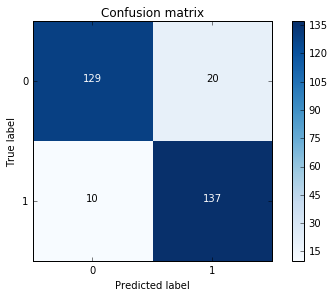

In [126]:
# 逻辑回归，C_parameter使用上面比较得到的最优参数。
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel()) #训练数据：欠采样的训练集
y_pred_undersample = lr.predict(X_test_undersample.values) #预测数据：欠采样的测试集

# 计算混淆矩阵
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 绘制 non-normalized 的混淆矩阵
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

So, the model is offering an 93.2% recall accuracy on the generalised unseen data (test set). Not a bad percentage to be the first try. However, recall this is a 93.2% recall accuracy measure on the undersampled test set.

## 上面结果还不错，看看在所有测试集上的效果

Recall metric in the testing dataset:  0.918367346939


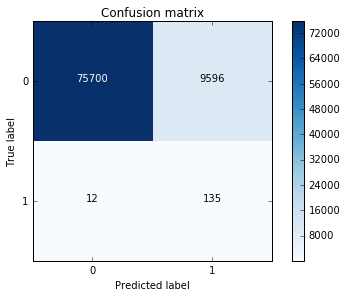

In [125]:
# 逻辑回归，C_parameter使用上面比较得到的最优参数。
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample,y_train_undersample.values.ravel()) #训练数据：欠采样的训练集
y_pred = lr.predict(X_test.values) #预测数据：所有数据的测试集

# 计算混淆矩阵
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 绘制 non-normalized 的混淆矩阵
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

**Still a very decent recall accuracy when applying it to a much larger and skewed dataset!**

## 绘制ROC曲线 和 Precision-Recall曲线

ROC全称是“受试者工作特征”（Receiver Operating Characteristic）曲线。我们根据学习器的预测结果对样例进行排序，排在前面的是学习器认为“最可能”是正例的样本，排在最后的则是学习器认为“最不可能”是正例的样本。按此顺序逐个把样本作为正例进行预测，每次计算出两个重要量的值，分别以它们为横、纵坐标作图，就得到了“ROC曲线”。纵轴是“真正例率”（True Positive Rate，TPR），横轴是“假正例率”（False Positive Rate，FPR）：

- TPR = TP / (TP + FN)
- FPR = FP / (TN + FP)

我个人对“真正例率”和“假正例率”通俗的理解：

- 真正例率：所有正例中，判别结果是正例的比率
- 假正例率：所有反例中，判别结果是正例的比率

AUC（Area Under ROC Curve）：ROC曲线下的面积。

同样的，我们根据学习器的结果对样例进行排序，按此顺序逐个把样本作为正例进行预测，每次可以计算出当前的查全率（Recall）、查准率（Precision）。以Precision为纵轴、Recall为横轴作图，就得到了Precision-Recall曲线，简称P-R曲线。

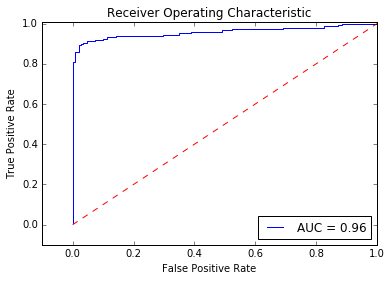

In [174]:
# 回归模型
lr = LogisticRegression(C = best_c, penalty='l1')
# decision_function(X): Predict confidence scores for samples.
# 模型学习、预测每个样本的得分
y_pred_undersample_score = lr.fit(X_train_undersample, y_train_undersample.values.ravel())\
.decision_function(X_test_undersample.values)

# 计算fpr、tpr
fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(), y_pred_undersample_score)
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.0])
plt.ylim([-0.1, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

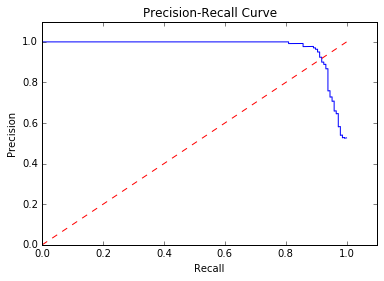

In [175]:
# 计算precision和recall
precision, recall, threshold = precision_recall_curve(y_test_undersample.values.ravel(), y_pred_undersample_score)

# 绘制P-R曲线
plt.title('Precision-Recall Curve')
plt.plot(recall, precision)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.10])
plt.ylim([0.0, 1.10])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()